# Importing Libraries


In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import pickle
import json
from google.colab import drive
import os
import gensim
from gensim.models import Word2Vec
import multiprocessing
from time import time 
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
import dill

import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Mounting on Google Drive Folder

In [3]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/BT4222 Project/Data')
os.getcwd()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/content/drive/My Drive/BT4222 Project/Data'

# Dumping or Loading Pickle Files

In [ ]:
# Save
#pickle.dump(w2v_model, open("reddit2012window10.sav", 'wb')) # Stores *.pkl file

# Load
w2v_model2012 = pickle.load(open("reddit2012_2016.sav", 'rb'))
w2v_model2019 = pickle.load(open("reddit2019.sav", 'rb'))
w2v_model = pickle.load(open("redditall.sav", 'rb'))
w2v_model2019dim60 = pickle.load(open("reddit2019dim60.sav", 'rb'))
w2v_model2019window10 = pickle.load(open("reddit2019window10.sav", 'rb'))

# Importing the Different Data Sets by the Year of the Reddit Comment

In [ ]:
train = pd.read_csv("2012_2016.csv", encoding = "ISO-8859-1")
train1 = pd.read_csv("2017.csv", encoding = "ISO-8859-1")
train2 = pd.read_csv("2018.csv", encoding = "ISO-8859-1")
train3 = pd.read_csv("2019.csv", encoding = "ISO-8859-1")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Combining the Different Data Sets into One Large Data Set

In [ ]:
traincomb = pd.concat([train,train1,train2,train3])

In [ ]:
train.tail(5)

,author,body,created_utc,date
1251933,cheese_ausar,put a tank in a mall,1482216956,2016-12-20 02:00:00
1251934,kyorah,My family runs a coffee store (Lam Yeo Coffee ...,1482216961,2016-12-20 02:00:00
1251935,gentlemansincebirth,Do you guys get to see who is making a booking...,1482217131,2016-12-20 02:00:00
1251936,highdiver_2000,Nice!,1482217166,2016-12-20 02:00:00
1251937,highdiver_2000,Nice!,1482217181,2016-12-20 02:00:00


# Data Preprocessing Functions

In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(sentences):
    print('Preprocessing Begins...')
    result = []
    for text in sentences:
        text = str(text)
        text = text.lower()
        text = re.sub(r"\'m", " am", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"won\'t", "will not", text)
        text = re.sub(r"can\'t", "cannot", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'bout", "about", text)
        text = re.sub(r"\'til", "until", text)
        text = re.sub(r"""[^a-zA-Z]"""," ",text)        
        text = re.sub(r"\bft\b|\bforeigntalent\b","foreign talent",text)
        text = re.sub(r"\bgovt\b|\bgahment\b|\bgahmen\b|\bgov\b","government",text)
        text = re.sub(r"\bpapies\b|\bpapees\b","pappies",text)
        text = re.sub(r"\bchi bai\b|\bchibai\b|\bchee bye\b|\bcheebye\b","cb",text)
        text = re.sub(r"\bfk\b|\bfck\b","fuck",text)
        text = re.sub(r"\bkanina\b|\bkanena\b","knn",text)
        text = re.sub(r"\blky\b","lee kuan yew",text)
        text = re.sub(r"\blhl\b|\bpm lee\b","lee hsien loong",text)
        if len(text.split()) == 0:
            continue
        then = []
        sw = stopwords.words('english')
        for word in text.split():
            if word not in sw:
              word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
              then.append(word)
        result.append(then)
    result = [" ".join(x) for x in result]
    print(result[:3], '\n')
    return result


# Preprocessing the Data

In [ ]:
clean_train = clean_text(train['body'])

Preprocessing Begins...
['dude face wreck', 'pretend thing singapore see photographic example already', 'happy new year try something different time go see firework relative last time gonna horribly crowd'] 



# Adding Bigrams along with Unigrams to the Term Dictionary

In [ ]:
sent = [row.split() for row in clean_train]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

# Checking the Number of Cores in my System

In [ ]:
cores = multiprocessing.cpu_count()
cores

2

# Setting the Word2Vec model with the following Parameters

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=10,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=10)

# Building the Vocabulary Table

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

# Training Word2Vec Model

In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# Making the Model Memory Efficient

In [ ]:
w2v_model.init_sims(replace=True)

# t-SNE Visualisation of Word Vectors Function

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

# Historical Semantics Visualisation

## 2012-2016

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


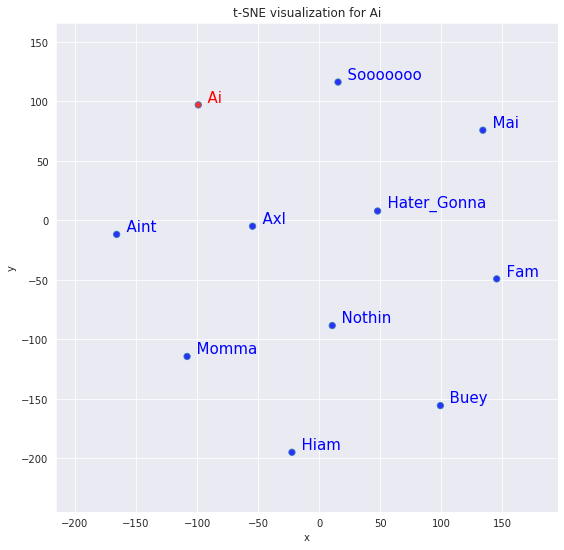

In [ ]:
tsnescatterplot(w2v_model2012, 'ai', [])

## 2019

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


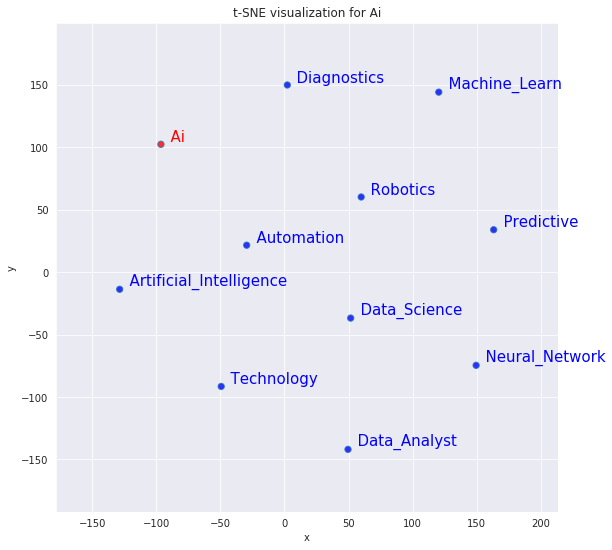

In [ ]:
tsnescatterplot(w2v_model2019, 'ai', [])

# New Words added into Singaporeans' Vocabulary Visualisation

## 2012-2016

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


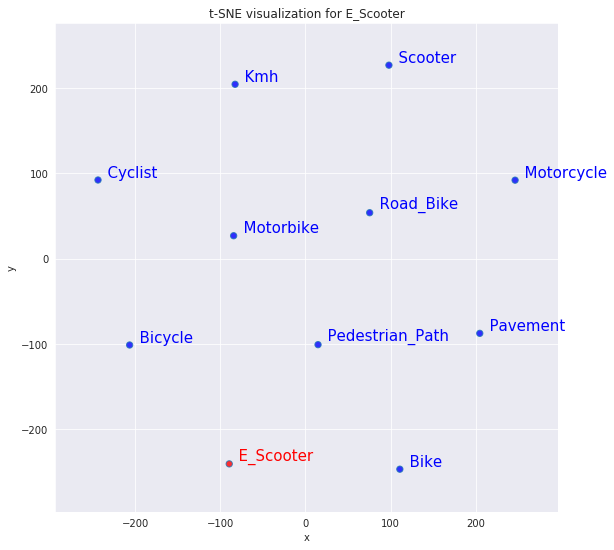

In [ ]:
tsnescatterplot(w2v_model2012, 'e_scooter', [])

## 2019

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


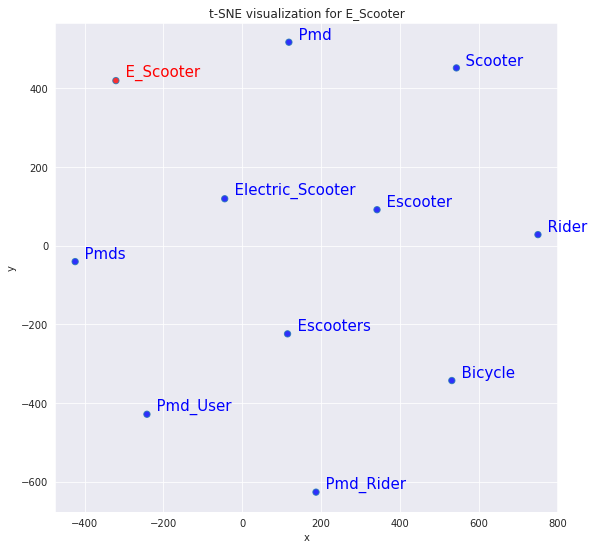

In [ ]:
tsnescatterplot(w2v_model2019, 'e_scooter', [])

# How Singaporeans Feel About Certain Political Issues Visualisation

## 2012-2016

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


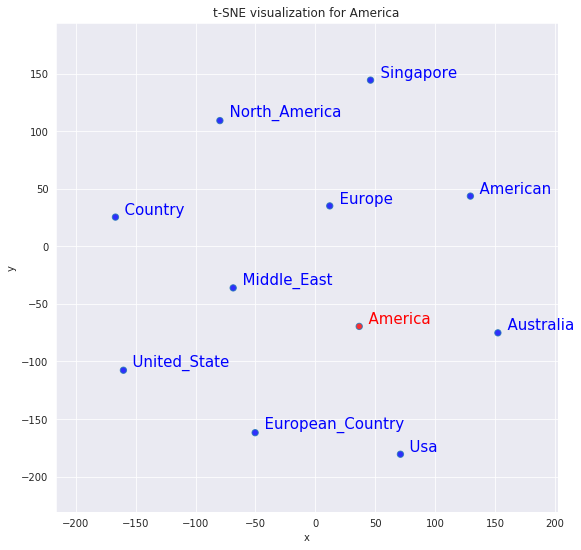

In [ ]:
tsnescatterplot(w2v_model2012, 'america', [])

## 2019

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


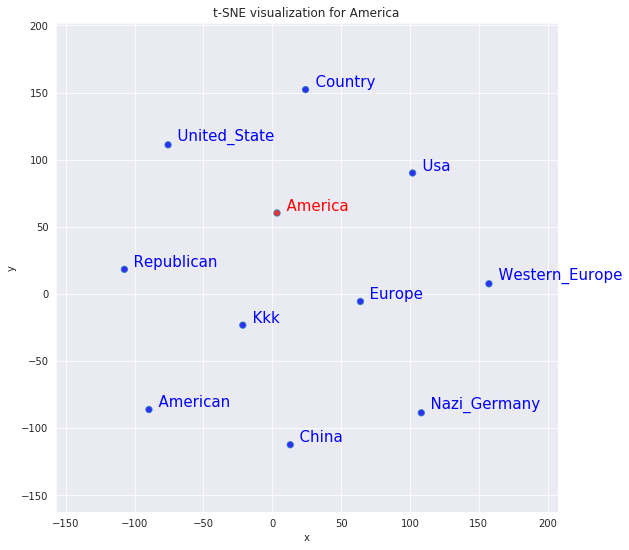

In [ ]:
tsnescatterplot(w2v_model2019, 'america', [])

# Checking Gender Bias through Analogical Relations

In [ ]:
w2v_model.wv.most_similar(positive=["male", "clothe"], negative=["female"], topn=3)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('change_diaper', 0.3829048275947571),
 ('feed', 0.3587833344936371),
 ('maid', 0.35833901166915894)]

In [ ]:
w2v_model.wv.most_similar(positive=["male", "strong"], negative=["female"], topn=3)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('weak', 0.5755622386932373),
 ('weaker', 0.5113364458084106),
 ('strength', 0.4879627823829651)]

# Insensitivity to other Countries or Groups of People Visualisation
 

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


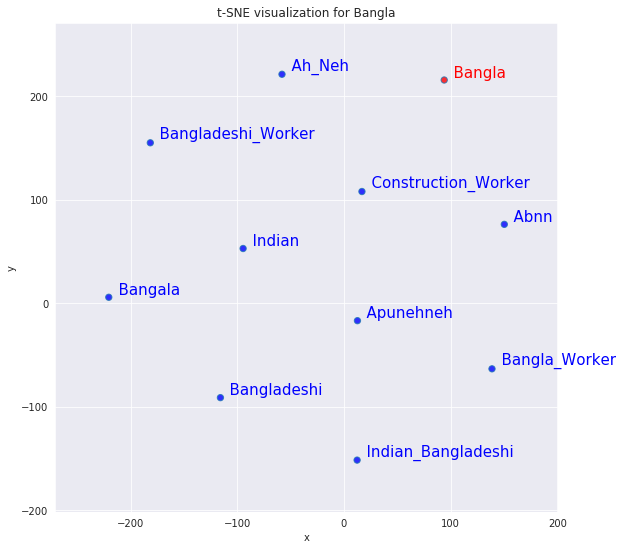

In [ ]:
tsnescatterplot(w2v_model, 'bangla', [])

# Comparing between a Context Window Size of 2 vs 10

## Context Window Size of 2

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


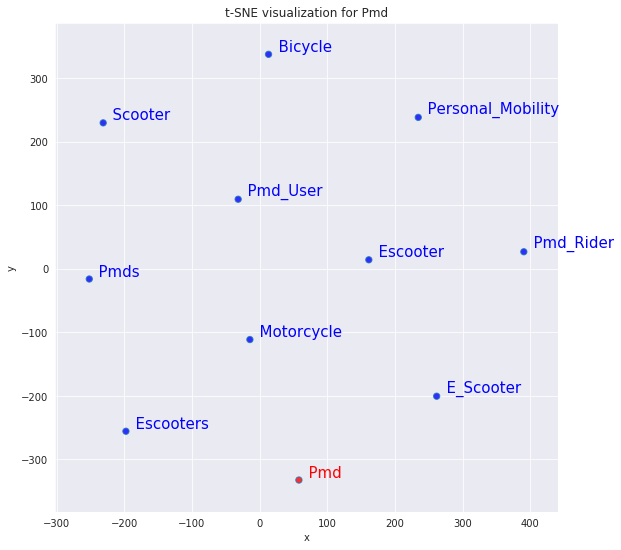

In [9]:
tsnescatterplot(w2v_model2019, 'pmd', [])

## Context Window Size of 10


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


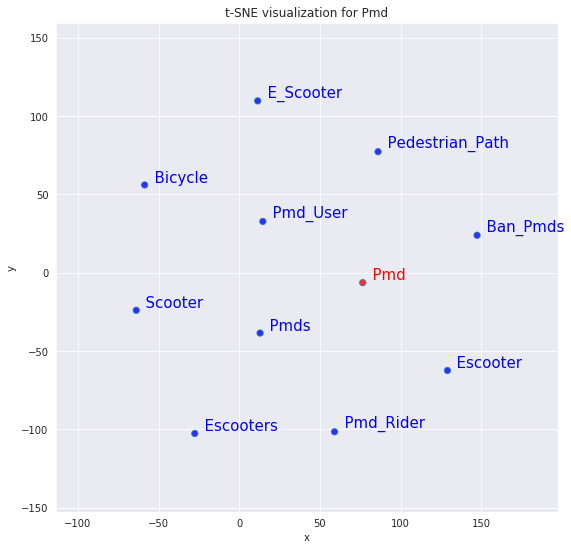

In [11]:
tsnescatterplot(w2v_model2019window10, 'pmd', [])